In [1]:
import torchvision.transforms.v2 as v2
from dl_toolbox import datamodules
from pathlib import Path

tf = v2.Compose(
    [
        v2.CenterCrop(280),
    ]
)
  
cityscapes = datamodules.Cityscapes(
    data_path='/data',
    merge='all19',
    train_tf=tf,
    test_tf=tf,
    batch_size=2,
    num_workers=0,
    pin_memory=False
)

/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
import timm
import torch

class ViTExtractor:
    """ This class facilitates extraction of features, descriptors, and saliency maps from a ViT.

    We use the following notation in the documentation of the module's methods:
    B - batch size
    h - number of heads. usually takes place of the channel dimension in pytorch's convention BxCxHxW
    p - patch size of the ViT. either 8 or 16.
    t - number of tokens. equals the number of patches + 1, e.g. HW / p**2 + 1. Where H and W are the height and width
    of the input image.
    d - the embedding dimension in the ViT.
    """

    def __init__(self, model_type='dino_vits8', device='cuda'):
        """
        :param model_type: A string specifying the type of model to extract from.
                          [dino_vits8 | dino_vits16 | dino_vitb8 | dino_vitb16 | vit_small_patch8_224 |
                          vit_small_patch16_224 | vit_base_patch8_224 | vit_base_patch16_224]
        :param stride: stride of first convolution layer. small stride -> higher resolution.
        :param model: Optional parameter. The nn.Module to extract from instead of creating a new one in ViTExtractor.
                      should be compatible with model_type.
        """
        self.model_type = model_type
        self.model = timm.create_model(
            model_type,
            pretrained=True,
            dynamic_img_size=True,
        )
        self.model_type = model_type
        self.device = device
        self.model.eval()
        self.model.to(self.device)
        self.p = self.model.patch_embed.patch_size[0]
        self.stride = self.model.patch_embed.proj.stride
        self._feats = []
        self.hook_handlers = []

    def _get_hook(self, facet):
        """
        generate a hook method for a specific block and facet.
        """
        if facet in ['attn', 'token']:
            def _hook(model, input, output):
                self._feats.append(output)
            return _hook

        if facet == 'query':
            facet_idx = 0
        elif facet == 'key':
            facet_idx = 1
        elif facet == 'value':
            facet_idx = 2
        else:
            raise TypeError(f"{facet} is not a supported facet.")

        def _inner_hook(module, input, output):
            input = input[0]
            B, N, C = input.shape
            qkv = module.qkv(input).reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
            self._feats.append(qkv[facet_idx]) #Bxhxtxd
        return _inner_hook

    def _register_hooks(self, layers, facet):
        """
        register hook to extract features.
        :param layers: layers from which to extract features.
        :param facet: facet to extract. One of the following options: ['key' | 'query' | 'value' | 'token' | 'attn']
        """
        for block_idx, block in enumerate(self.model.blocks):
            if block_idx in layers:
                if facet == 'token':
                    self.hook_handlers.append(block.register_forward_hook(self._get_hook(facet)))
                elif facet == 'attn':
                    self.hook_handlers.append(block.attn.attn_drop.register_forward_hook(self._get_hook(facet)))
                elif facet in ['key', 'query', 'value']:
                    self.hook_handlers.append(block.attn.register_forward_hook(self._get_hook(facet)))
                else:
                    raise TypeError(f"{facet} is not a supported facet.")

    def _unregister_hooks(self) -> None:
        """
        unregisters the hooks. should be called after feature extraction.
        """
        for handle in self.hook_handlers:
            handle.remove()
        self.hook_handlers = []

    def _extract_features(self, batch, layers, facet):
        """
        extract features from the model
        :param batch: batch to extract features for. Has shape BxCxHxW.
        :param layers: layer to extract. A number between 0 to 11.
        :param facet: facet to extract. One of the following options: ['key' | 'query' | 'value' | 'token' | 'attn']
        :return : tensor of features.
                  if facet is 'key' | 'query' | 'value' has shape Bxhxtxd
                  if facet is 'attn' has shape Bxhxtxt
                  if facet is 'token' has shape Bxtxd
        """
        B, C, H, W = batch.shape
        self._feats = []
        self._register_hooks(layers, facet)
        _ = self.model(batch)
        self._unregister_hooks()
        self.num_patches = (1 + (H - self.p) // self.stride[0], 1 + (W - self.p) // self.stride[1])
        return self._feats

    def extract_descriptors(self, batch, layer, facet, bin, include_cls):
        """
        extract descriptors from the model
        :param batch: batch to extract descriptors for. Has shape BxCxHxW.
        :param layers: layer to extract. A number between 0 to 11.
        :param facet: facet to extract. One of the following options: ['key' | 'query' | 'value' | 'token']
        :param bin: apply log binning to the descriptor. default is False.
        :return: tensor of descriptors. Bx1xtxd' where d' is the dimension of the descriptors.
        """
        assert facet in ['key', 'query', 'value', 'token'], f"""{facet} is not a supported facet for descriptors. 
                                                             choose from ['key' | 'query' | 'value' | 'token'] """
        self._extract_features(batch, [layer], facet)
        x = self._feats[0]
        if facet == 'token':
            x.unsqueeze_(dim=1) #Bx1xtxd
        if not include_cls:
            x = x[:, :, 1:, :]  # remove cls token
        else:
            assert not bin, "bin = True and include_cls = True are not supported together, set one of them False."
        if not bin:
            desc = x.permute(0, 2, 3, 1).flatten(start_dim=-2, end_dim=-1).unsqueeze(dim=1)  # Bx1xtx(dxh)
        else:
            desc = self._log_bin(x)
        return desc

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
extractor = ViTExtractor('vit_small_patch14_dinov2', device=device)
cityscapes.setup(stage='fit')
for batch in cityscapes.val_dataloader():
    with torch.no_grad():
        #image_batch, image_pil = extractor.preprocess(args.image_path, args.load_size)
        #print(f"Image {args.image_path} is preprocessed to tensor of size {image_batch.shape}.")
        descriptors1 = extractor.extract_descriptors(batch['image'].to(device), 11, 'token', bin=False, include_cls=False)
        print(f"Descriptors are of size: {descriptors1.shape}")
        #torch.save(descriptors, args.output_path)
        #print(f"Descriptors saved to: {args.output_path}")
    break

Descriptors are of size: torch.Size([2, 1, 400, 384])


In [27]:
from dl_toolbox.modules import FeatureExtractor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
feature_extractor = FeatureExtractor('vit_small_patch14_dinov2').to(device)
feature_extractor.encoder.prune_intermediate_layers(11,prune_norm=True,prune_head=False)
cityscapes.setup(stage='fit')
for batch in cityscapes.val_dataloader():
    with torch.no_grad():
        #image_batch, image_pil = extractor.preprocess(args.image_path, args.load_size)
        #print(f"Image {args.image_path} is preprocessed to tensor of size {image_batch.shape}.")
        descriptors2 = feature_extractor(batch['image'].to(device))[:,1:]
        print(f"Descriptors are of size: {descriptors2.shape}")
        #torch.save(descriptors, args.output_path)
        #print(f"Descriptors saved to: {args.output_path}")
    break

Descriptors are of size: torch.Size([2, 400, 384])


In [28]:
torch.allclose(descriptors1.squeeze(), descriptors2)

True

In [29]:
def chunk_cosine_sim(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """ Computes cosine similarity between all possible pairs in two sets of vectors.
    Operates on chunks so no large amount of GPU RAM is required.
    :param x: an tensor of descriptors of shape Bx1x(t_x)xd' where d' is the dimensionality of the descriptors and t_x
    is the number of tokens in x.
    :param y: a tensor of descriptors of shape Bx1x(t_y)xd' where d' is the dimensionality of the descriptors and t_y
    is the number of tokens in y.
    :return: cosine similarity between all descriptors in x and all descriptors in y. Has shape of Bx1x(t_x)x(t_y) """
    result_list = []
    num_token_x = x.shape[2]
    for token_idx in range(num_token_x):
        token = x[:, :, token_idx, :].unsqueeze(dim=2)  # Bx1x1xd'
        result_list.append(torch.nn.CosineSimilarity(dim=3)(token, y))  # Bx1xt
    return torch.stack(result_list, dim=2)  # Bx1x(t_x)x(t_y)

In [60]:
from PIL import Image
import torchvision.transforms.v2 as v2

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

def read_img(path, size, mean, std):
    pil_image = Image.open(path).convert('RGB')
    if size is not None:
        pil_image = v2.Resize(size)(pil_image)
    prep = v2.Compose([
        v2.ToTensor(),
        v2.Normalize(mean=mean, std=std)
    ])
    prep_img = prep(pil_image)[None, ...]
    return prep_img, pil_image

In [65]:
import matplotlib.pyplot as plt 

import numpy as np

def show_similarity_interactive(image_path_a: str, image_path_b: str, position, load_size: int = 224, layer: int = 11,
                                facet: str = 'key', bin: bool = False, model_type: str = 'dino_vits8',
                                num_sim_patches: int = 1):
    """
     finding similarity between a descriptor in one image to the all descriptors in the other image.
     :param image_path_a: path to first image.
     :param image_path_b: path to second image.
     :param load_size: size of the smaller edge of loaded images. If None, does not resize.
     :param layer: layer to extract descriptors from.
     :param facet: facet to extract descriptors from.
     :param bin: if True use a log-binning descriptor.
     :param model_type: type of model to extract descriptors from.
     :param num_sim_patches: number of most similar patches from image_b to plot.
    """
    # extract descriptors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    extractor = ViTExtractor(model_type, device=device)
    patch_size = extractor.model.patch_embed.patch_size[0]

        
    image_batch_a, image_pil_a = read_img(image_path_a, load_size, imagenet_mean, imagenet_std)
    image_batch_b, image_pil_b = read_img(image_path_b, load_size, imagenet_mean, imagenet_std)
    descs_a = extractor.extract_descriptors(image_batch_a.to(device), layer, facet, bin, include_cls=True)
    num_patches_a, load_size_a = extractor.num_patches, load_size
    descs_b = extractor.extract_descriptors(image_batch_b.to(device), layer, facet, bin, include_cls=True)
    num_patches_b, load_size_b = extractor.num_patches, load_size
    stride = extractor.stride[0]

    # plot
    fig, axes = plt.subplots(1, 3)
    [axi.set_axis_off() for axi in axes.ravel()]
    visible_patches = []
    radius = patch_size // 2
    # plot image_a and the chosen patch. if nothing marked chosen patch is cls patch.
    axes[0].imshow(image_pil_a)

    # calculate and plot similarity between image1 and image2 descriptors
    similarities = chunk_cosine_sim(descs_a, descs_b)
    
    #curr_similarities = similarities[0, 0, 0, 1:]
    #print(curr_similarities.shape)
    #print(num_patches_b)
    ## similarity to all spatial descriptors, without cls token
    #curr_similarities = curr_similarities.reshape(num_patches_b)
    #axes[1].imshow(curr_similarities.cpu().numpy(), cmap='jet')
    #
    ## plot image_b and the closest patch in it to the chosen patch in image_a
    #axes[2].imshow(image_pil_b)
    #sims, idxs = torch.topk(curr_similarities.flatten(), num_sim_patches)
    #for idx, sim in zip(idxs, sims):
    #    y_descs_coor, x_descs_coor = idx // num_patches_b[1], idx % num_patches_b[1]
    #    center = ((x_descs_coor - 1) * stride + stride + patch_size // 2 - .5,
    #              (y_descs_coor - 1) * stride + stride + patch_size // 2 - .5)
    #    patch = plt.Circle(center, radius, color=(1, 0, 0, 0.75))
    #    axes[2].add_patch(patch)
    #    visible_patches.append(patch)
    #plt.draw()
    


    y_coor, x_coor = position
    new_H = patch_size / stride * (load_size_a[0] // patch_size - 1) + 1
    new_W = patch_size / stride * (load_size_a[1] // patch_size - 1) + 1
    y_descs_coor = int(new_H / load_size_a[0] * y_coor)
    x_descs_coor = int(new_W / load_size_a[1] * x_coor)

    # draw chosen point
    center = ((x_descs_coor - 1) * stride + stride + patch_size // 2 - .5,
              (y_descs_coor - 1) * stride + stride + patch_size // 2 - .5)
    patch = plt.Circle(center, radius, color=(1, 0, 0, 0.75))
    axes[0].add_patch(patch)

    # get and draw current similarities
    raveled_desc_idx = num_patches_a[1] * y_descs_coor + x_descs_coor
    reveled_desc_idx_including_cls = raveled_desc_idx + 1
    curr_similarities = similarities[0, 0, reveled_desc_idx_including_cls, 1:]
    curr_similarities = curr_similarities.reshape(num_patches_b)
    axes[1].imshow(curr_similarities.cpu().numpy(), cmap='jet')

    # get and draw most similar points
    axes[2].imshow(image_pil_b)
    sims, idxs = torch.topk(curr_similarities.flatten(), num_sim_patches)
    for idx, sim in zip(idxs, sims):
        y_descs_coor, x_descs_coor = idx // num_patches_b[1], idx % num_patches_b[1]
        center = ((x_descs_coor - 1) * stride + stride + patch_size // 2 - .5,
                  (y_descs_coor - 1) * stride + stride + patch_size // 2 - .5)
        patch = plt.Circle(center, radius, color=(1, 0, 0, 0.75))
        axes[2].add_patch(patch)
    plt.draw()

    

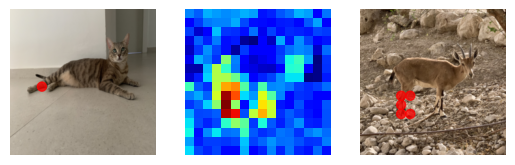

In [72]:
with torch.no_grad():
    show_similarity_interactive('./images/cat.jpg', './images/ibex.jpg', (120,50), (224, 224), 11, 'token', False,
                                'vit_small_patch14_dinov2', 5)

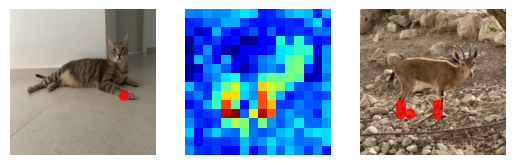

In [73]:
with torch.no_grad():
    show_similarity_interactive('./images/cat.jpg', './images/ibex.jpg', (130,180), (224, 224), 11, 'token', False,
                                'vit_small_patch14_dinov2', 5)

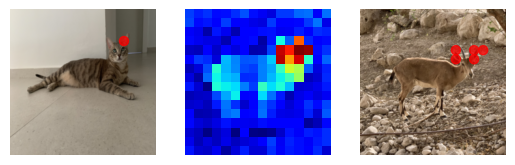

In [74]:
with torch.no_grad():
    show_similarity_interactive('./images/cat.jpg', './images/ibex.jpg', (50,180), (224, 224), 11, 'token', False,
                                'vit_small_patch14_dinov2', 5)

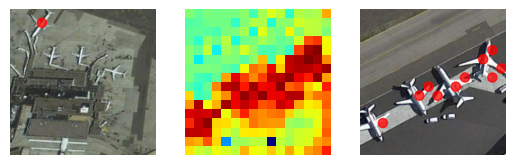

In [87]:
 with torch.no_grad():
    show_similarity_interactive('/data/NWPU-RESISC45/airplane/airplane_077.jpg', '/data/NWPU-RESISC45/airplane/airplane_312.jpg', (20,50), (224, 224), 11, 'token', False,
                                'vit_small_patch14_dinov2', 10)

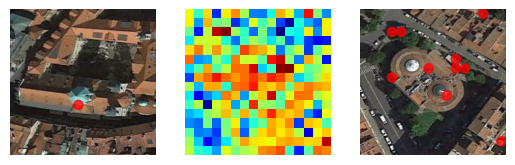

In [88]:
 with torch.no_grad():
    show_similarity_interactive('/data/NWPU-RESISC45/church/church_048.jpg', '/data/NWPU-RESISC45/church/church_312.jpg', (150,110), (224, 224), 11, 'token', False,
                                'vit_small_patch14_dinov2', 10)

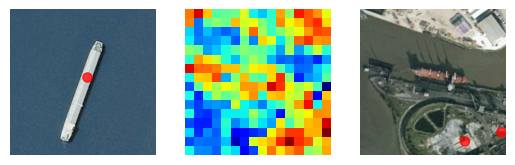

In [86]:
 with torch.no_grad():
    show_similarity_interactive('/data/NWPU-RESISC45/ship/ship_048.jpg', '/data/NWPU-RESISC45/ship/ship_312.jpg', (110,115), (224, 224), 11, 'token', False,
                                'vit_small_patch14_dinov2', 2)

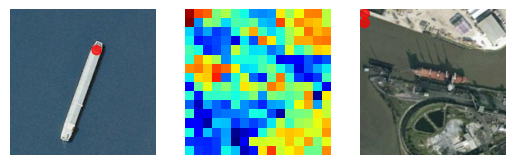

In [94]:
 with torch.no_grad():
    show_similarity_interactive('/data/NWPU-RESISC45/ship/ship_048.jpg', '/data/NWPU-RESISC45/ship/ship_312.jpg', (60,135), (224, 224), 11, 'token', False,
                                'vit_small_patch14_dinov2', 2)

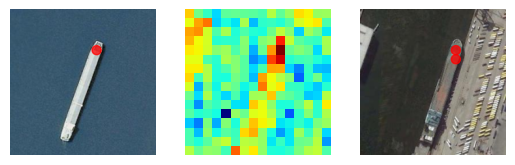

In [93]:
 with torch.no_grad():
    show_similarity_interactive('/data/NWPU-RESISC45/ship/ship_048.jpg', '/data/NWPU-RESISC45/ship/ship_073.jpg', (60,135), (224, 224), 11, 'token', False,
                                'vit_small_patch14_dinov2', 2)